# Part 2: Quantiles

## Introduction

In this tutorial, we will explore the quantile method supported by OpenDP. Specifically, we will first use the quantile method directly, and then explain its primary steps.

This tutorial will use the Labor Force Survey data (see the Pre-Processing Notebook for more information) and some of the concepts introduced in Part 1 - Data Exploration. TODO: Add relative links

In [ ]:
pip install "opendp[polars]"

In [2]:
import numpy as np
import polars as pl
import opendp.prelude as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.enable_features("contrib")

If the "sample_FR_LFS.csv" file exists, then follow the code for importing the dataset as is. Otherwise follow the instructions from Preprocessing.ipynb to compile the dataset. TODO: Relative link

In [3]:
# reading in the data
df = pl.scan_csv("sample_FR_LFS.csv", infer_schema_length=1000, ignore_errors=True)

For more information on defining the compositor, see the Part 1 Notebook on Data Exploration methods!

In [4]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=1),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10,
    margins={
        ("AGE", ): dp.Margin(public_info="keys", max_partition_length=60_000_000),
        (): dp.Margin(public_info="keys", max_partition_length=60_000_000),
    },
)

## Using the Quantile Method Directly

Before we get into the quantile method, let's try out the median method directly. We also will need to impute the null values with the mean. 

In [18]:
mean_age = df.select(pl.col("AGE")).mean().collect()
candidates = list(range(100))

In [6]:
actual_median = list(df.select(pl.col("AGE").median()).collect())[0][0]
print(f"Actual Median: {actual_median}")

dp_median = list(context.query().select(
    pl.col("AGE").fill_null(mean_age).dp.median(candidates)
).release().collect())[0][0]
print(f"Differentially Private Median: {dp_median}")

Actual Median: 47.0
Differentially Private Median: 46


Let's find the age at the 30th quantile! To compute it using the quantile method directly, follow these steps:

1. Select the variable you are interested in. In this case we chose "AGE"
2. Fill in null values. We'll impute the values with the mean age.
3. Specify the following parameters in the quantile method:

    a. Quantile: This is between 0 and 1. We provide 0.30. 
    
    b. A range of possible values for your quantiles. This will depend on your specific domain. We know that ages are generally between 0 and 100, we use those as our candidates, so our results will be limited to these values.

In [7]:
quantile = 0.3

dp_quantile_30 = context.query().select(
    pl.col("AGE").fill_null(mean_age).dp.quantile(quantile, candidates)
).release().collect()
dp_quantile_30

AGE
i64
30


### Multiple Quantiles for the Same Variable

To compute multiple quantiles for the same variable, we can use list comprehension to specify multiple quantiles in our query.

In [21]:
multiple_quantiles_actual = df.select(
    [pl.col("AGE").fill_null(mean_age).quantile(q).alias(f"Quantile_{q}") for q in [0.2, 0.4, 0.6, 0.8]]
).collect()
multiple_quantiles_actual

Quantile_0.2,Quantile_0.4,Quantile_0.6,Quantile_0.8
f64,f64,f64,f64
20.0,32.0,47.0,65.0


In [17]:
multiple_quantiles = context.query().select(
    [pl.col("AGE").fill_null(mean_age).dp.quantile(q, candidates).alias(f"Quantile_{q}") for q in [0.2, 0.4, 0.6, 0.8]]
).release().collect()
multiple_quantiles

Quantile_0.2,Quantile_0.4,Quantile_0.6,Quantile_0.8
i64,i64,i64,i64
20,32,58,72


Here we computed some sample quantiles and the differentially private values are relatively close to the actual values. Notice that we also specified a different alias for each column. Polars uses the original column name on derived columns, so aliases are needed to distinguish these columns.



## Breaking Down the Quantile Method

Now that you know how to use the quantile method, we can also break it down for you a little more.

You might also wonder why there are multiple steps to the quantile method. Why don't we just add noise directly?

Directly adding noise can change a particular point and alter the sensitivity (max - min) greatly, so constructing a differentially private quantile requires more sophistication.

### 1. Compute the Discrete Quantile Score for Each Candidate

The `discrete_quantile_score` function takes in the same parameters as the quantile function. It computes a utility score for each candidate quantile that represents how close each candidate is to the true quantile. Lower scores are closer to 0 are more accurate.

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_50483/2347966570.py:7: RuntimeWarning: invalid value encountered in cast
  age_list = list(df.select("AGE").collect().get_column("AGE").to_numpy().astype('int32'))


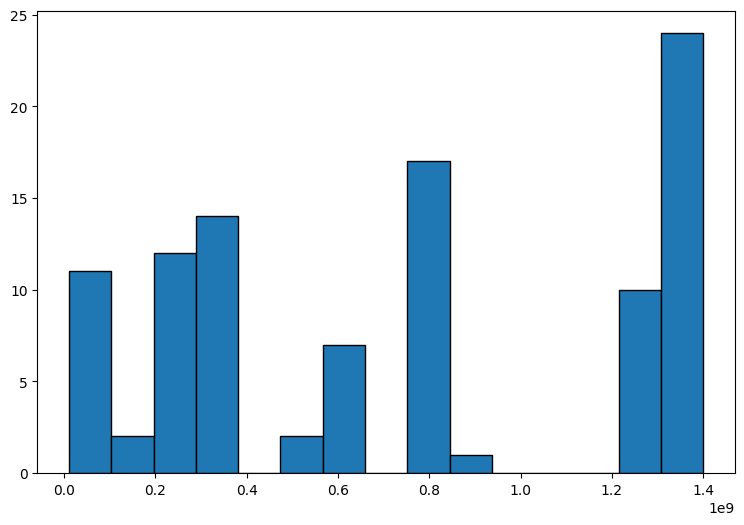

In [33]:
#make the transformation get discrete scores per candidate
discrete_scores = dp.t.make_quantile_score_candidates(dp.vector_domain(dp.atom_domain(T=int)), 
                                    dp.symmetric_distance(), 
                                    candidates, 
                                    quantile)
#get the ages from the dataset and change its type for the transformation
age_list = list(df.select("AGE").collect().get_column("AGE").to_numpy().astype('int32'))
#apply the transformation to the discrete scores
discrete_scores_list = discrete_scores(age_list)
#plot the scores
fig, ax = plt.subplots(figsize = (9, 6))
ax.hist(discrete_scores_list, bins=15, edgecolor="black");

### 2. Add Noise and Return Index of Candidate with Lowest Score

We now pass the scores to the `make_report_noisy_max_gumbel` function. This adds Gumbel noise to the score and returns index of the candidate that has the lowest score.

In [31]:
input_space = dp.vector_domain(dp.atom_domain(T=int)), dp.linf_distance(T=int)
select_index_measurement = dp.m.make_report_noisy_max_gumbel(*input_space, scale=1.0, optimize='max')
select_index_measurement

Measurement(
    input_domain   = VectorDomain(AtomDomain(T=i32)),
    input_metric   = LInfDistance(T=i32),
    output_measure = MaxDivergence(f64))

In [34]:
#pass the discrete scores to the measurement
noisy_index = select_index_measurement(discrete_scores_list)
noisy_index

82

### 3. Return the Corresponding Quantile Value

We pass the index obtained in the last function to `_index_candidates function` which maps the index to its corresponding candidate value. This differentially private quantile estimate is our final result! In this case our candidates list was an ordered, numerical list of human ages, which generally range to 100 so our noisy index and differentially private value are the same. In most applications, it won't be!

In [35]:
dp_quantile_value = candidates[noisy_index]
dp_quantile_value

82

## Conclusion

In this notebook, we covered how to use the OpenDP Context API with Polars to compute differentially private quantiles and explained how the differentially private quantile method works. 
